In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
import missingno as msno
import sklearn.ensemble as ens
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from utils.ml import best_run, fit_transform_display
from utils.PCA_Transformer import PCA_Transform
from utils.utils import generate_profile, load_config, load_data

/home/piotr/projects/ml-project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data from the locally stored files (it's assumed data has been downloaded from the remote source independently)

In [2]:
config = load_config()
df_apartments = load_data(config, "apartments", False)

Create basic pandas profile for original dataset:

In [3]:
generate_profile(df_apartments)

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 85.52it/s]


From the report we can learn that several values in the input data is missing, there are duplicated rows in the data and some columns are strongly correlated

## Duplicates

It turns out there are no phycial or logical duplicates in the the 1 month of data:

In [4]:
dps_physical = df_apartments.duplicated(keep="last")
dps_phycical_count = dps_physical[dps_physical == True].count()
dps_logical = df_apartments.duplicated("id", keep="last")
dps_logical_count = dps_logical[dps_logical == True].count()
print(f"There are {dps_phycical_count} physical douplicates and {dps_logical_count} logical duplicates")

There are 0 physical douplicates and 0 logical duplicates


## Missing values

Let's look at the missing value distribution

<Axes: >

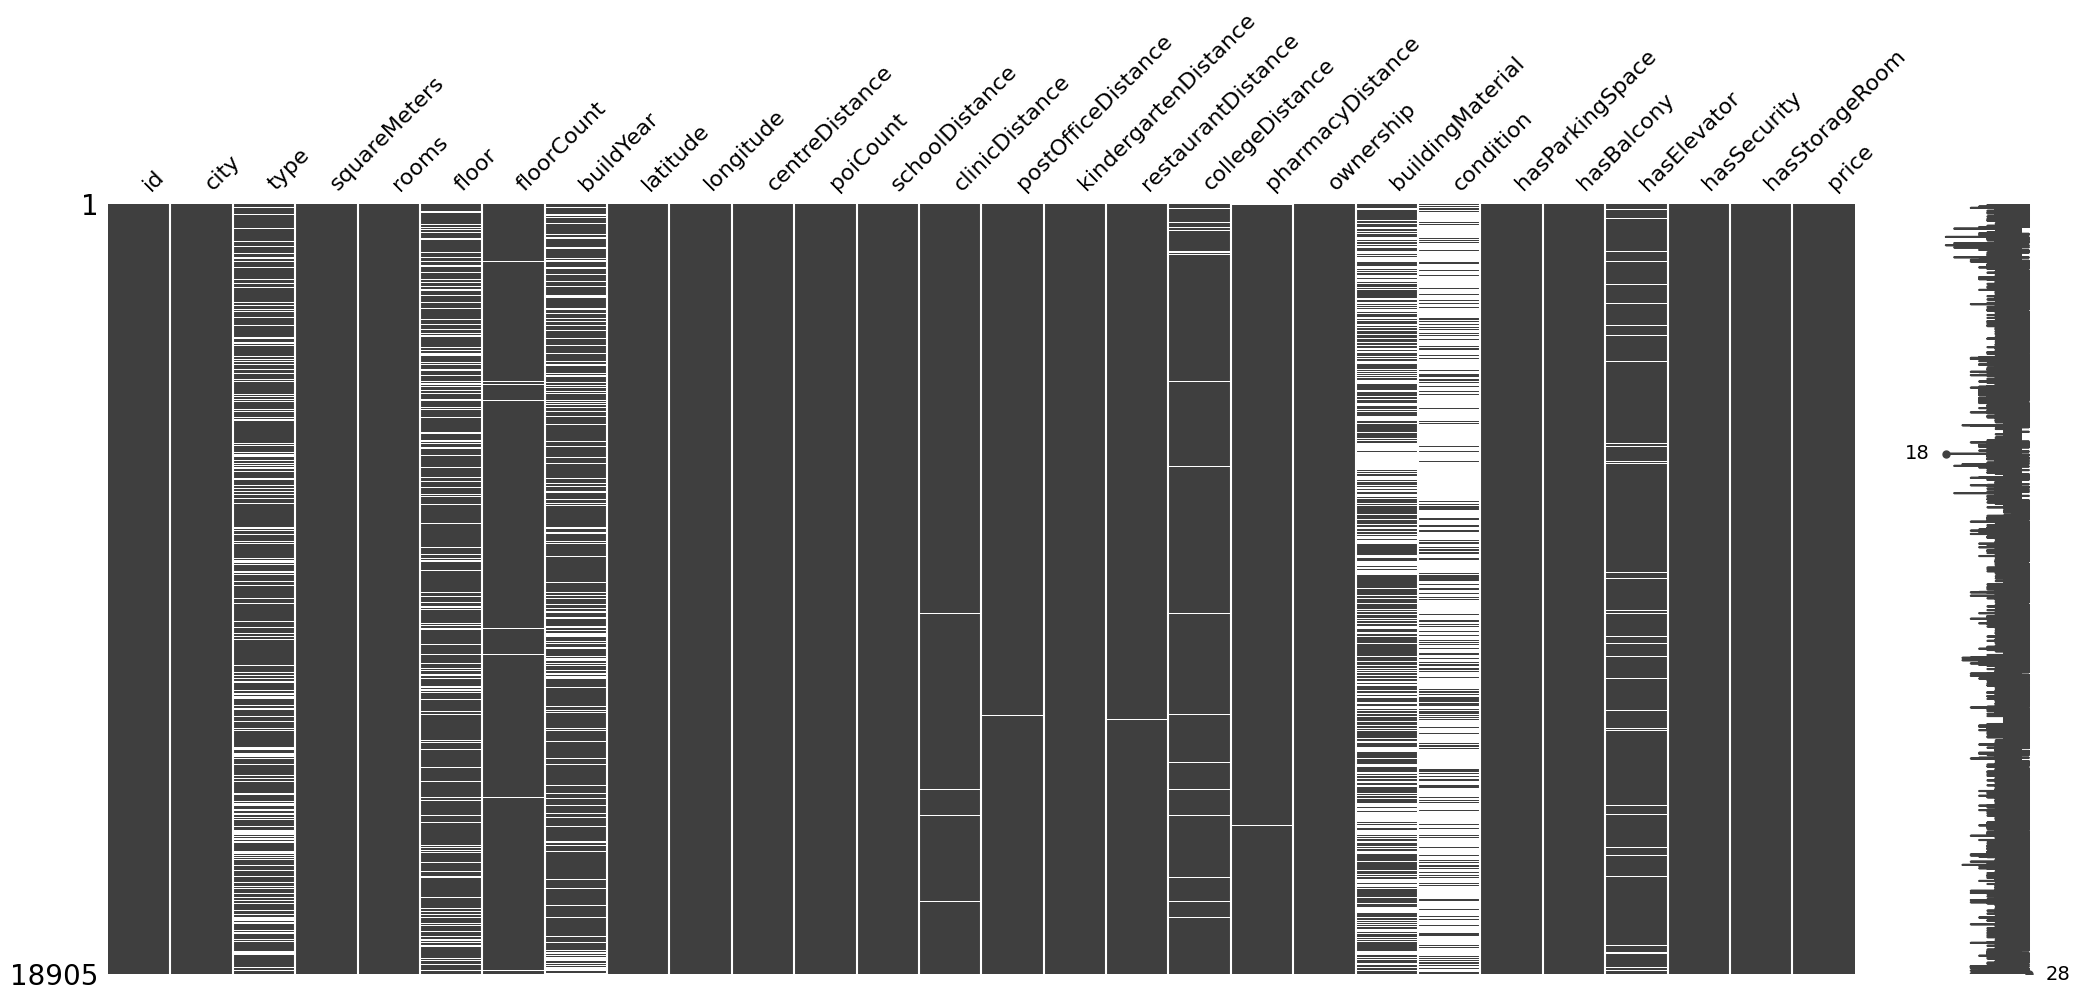

In [5]:
msno.matrix(df_apartments)

<Axes: >

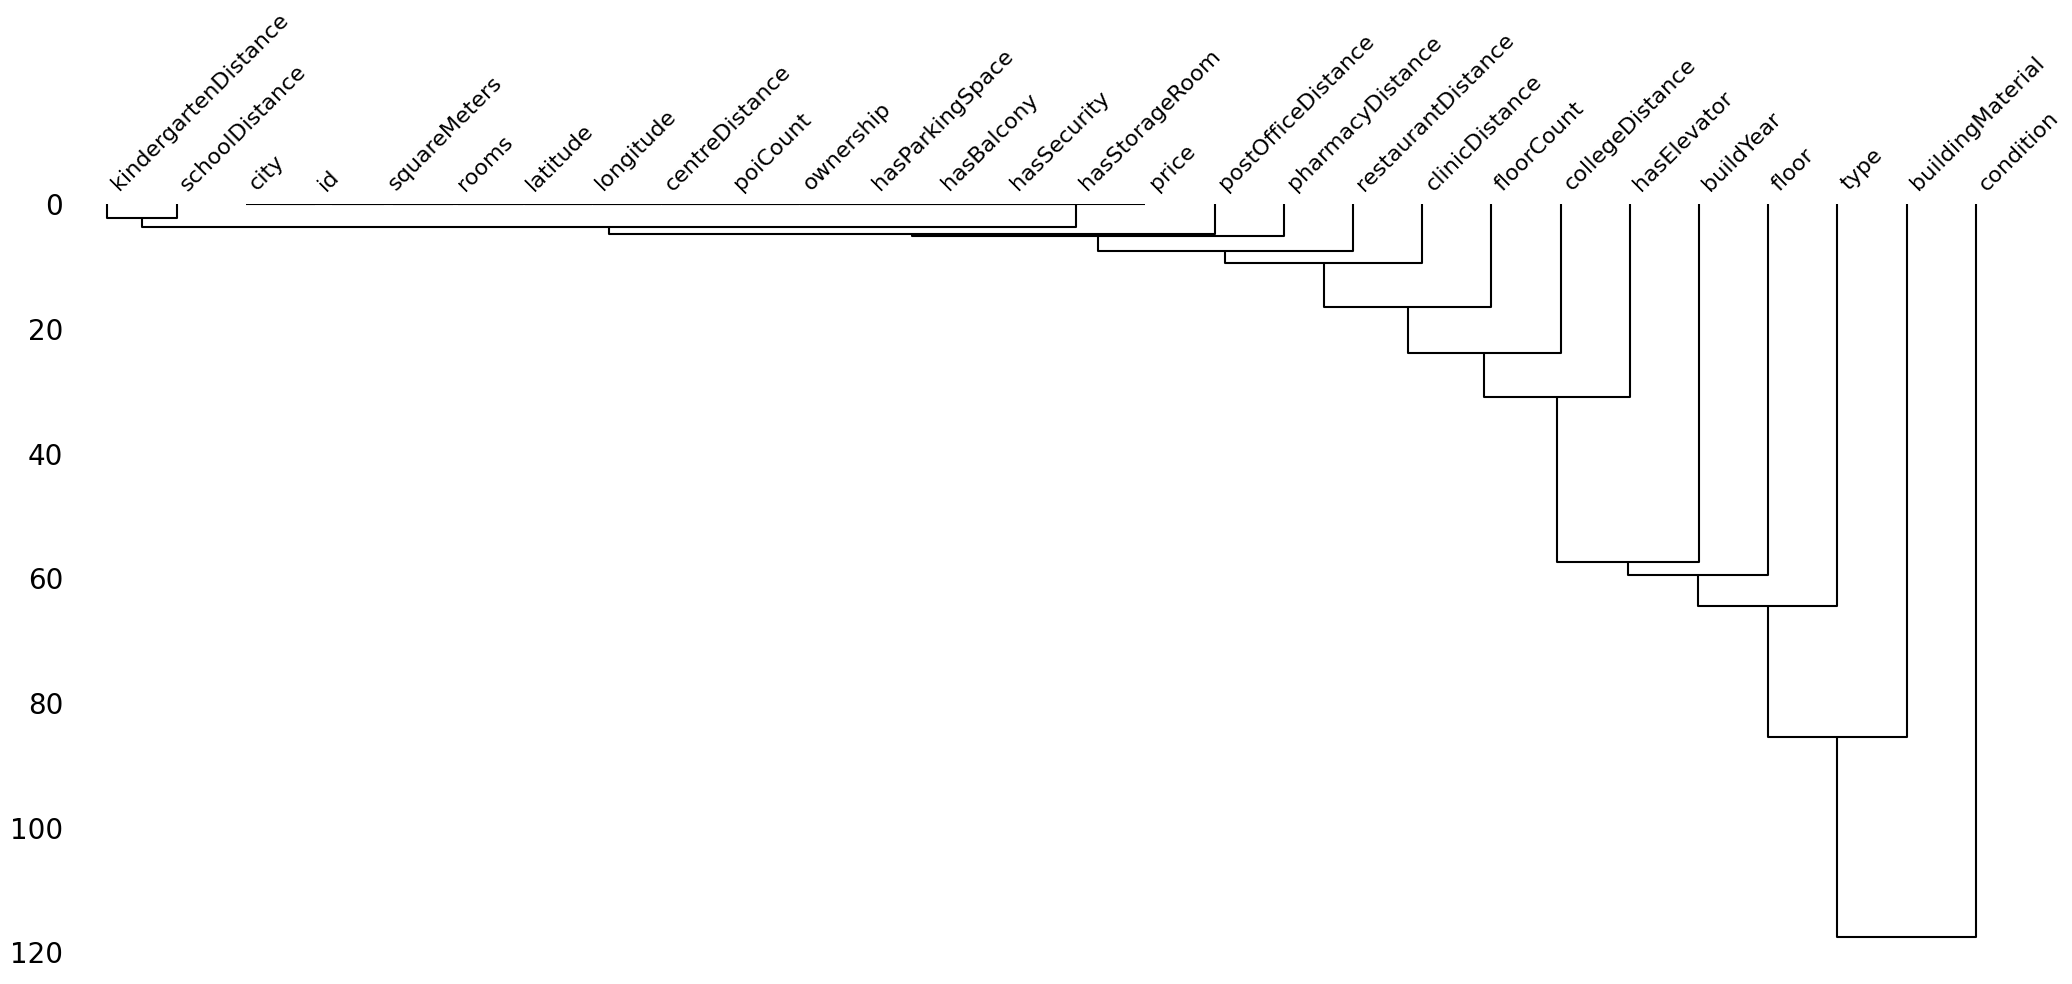

In [7]:
msno.dendrogram(df_apartments)

We can see that *Distance columns tend to influence eache others presence which may indicate that this information may from from the same source. Furthermore some columns have high share of missing values

In [9]:
df_apartments.isna().sum().sort_values(ascending=False) / len(df_apartments) * 100

condition               75.874107
buildingMaterial        39.074319
type                    21.364718
floor                   18.185665
buildYear               17.302301
hasElevator              4.898175
collegeDistance          2.988627
floorCount               1.385877
clinicDistance           0.465485
restaurantDistance       0.306797
pharmacyDistance         0.142819
postOfficeDistance       0.132240
schoolDistance           0.074054
kindergartenDistance     0.068765
hasParkingSpace          0.000000
ownership                0.000000
hasSecurity              0.000000
hasStorageRoom           0.000000
hasBalcony               0.000000
id                       0.000000
city                     0.000000
poiCount                 0.000000
centreDistance           0.000000
longitude                0.000000
latitude                 0.000000
rooms                    0.000000
squareMeters             0.000000
price                    0.000000
dtype: float64

We've decided to delete 3 columns:
* id - it's a hash, so it doesnt hold any meaningful information
* "condition","buildingMaterial" - too many missing values

In [19]:
df_apartments_1 = df_apartments.drop(["id", "condition", "buildingMaterial"], axis=1).drop_duplicates()

Let's look at the distribution of field types:

In [20]:
num_columns = list(df_apartments_1.select_dtypes("number").columns.values)
obj_columns = list(df_apartments_1.select_dtypes("object").columns.values)
print(len(num_columns), len(obj_columns), len(df_apartments.columns))

17 8 28


We can see that remaining columns are either numerical or strings - the latter ones can hopefully be turned into categories. However it must be checked first if there any nulls:

In [21]:
df_apartments_1[obj_columns].nunique()

city               15
type                3
ownership           2
hasParkingSpace     2
hasBalcony          2
hasElevator         2
hasSecurity         2
hasStorageRoom      2
dtype: int64

In [22]:
df_apartments_1[obj_columns].isna().sum().sort_values(ascending=False) / len(df_apartments_1) * 100

type               21.312002
hasElevator         4.922682
city                0.000000
ownership           0.000000
hasParkingSpace     0.000000
hasBalcony          0.000000
hasSecurity         0.000000
hasStorageRoom      0.000000
dtype: float64

We're going to replace missing values with constant value 'Other':

In [23]:
df_apartments_1.loc[df_apartments_1["type"].isna(), ["type"]] = "Other"
df_apartments_1.loc[df_apartments_1["hasElevator"].isna(), ["hasElevator"]] = "Other"

And now no missing values are present so we can turn object types into categorical:

In [24]:
df_apartments_1[obj_columns].isna().sum().sort_values(ascending=False) / len(df_apartments) * 100

city               0.0
type               0.0
ownership          0.0
hasParkingSpace    0.0
hasBalcony         0.0
hasElevator        0.0
hasSecurity        0.0
hasStorageRoom     0.0
dtype: float64

In [25]:
df_apartments_1[df_apartments_1.select_dtypes("object").columns.to_list()] = df_apartments_1[
    df_apartments_1.select_dtypes("object").columns.to_list()
].astype("category")
df_apartments_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18689 entries, 0 to 18904
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   city                  18689 non-null  category
 1   type                  18689 non-null  category
 2   squareMeters          18689 non-null  float64 
 3   rooms                 18689 non-null  float64 
 4   floor                 15297 non-null  float64 
 5   floorCount            18430 non-null  float64 
 6   buildYear             15466 non-null  float64 
 7   latitude              18689 non-null  float64 
 8   longitude             18689 non-null  float64 
 9   centreDistance        18689 non-null  float64 
 10  poiCount              18689 non-null  float64 
 11  schoolDistance        18675 non-null  float64 
 12  clinicDistance        18602 non-null  float64 
 13  postOfficeDistance    18664 non-null  float64 
 14  kindergartenDistance  18676 non-null  float64 
 15  restaur

Our categorical features don't have any missing values but there are several numerical columns with missing values

In [26]:
df_apartments_1.isna().sum().sort_values(ascending=False) / len(df_apartments_1) * 100

floor                   18.149714
buildYear               17.245438
collegeDistance          2.975012
floorCount               1.385842
clinicDistance           0.465514
restaurantDistance       0.304992
pharmacyDistance         0.144470
postOfficeDistance       0.133769
schoolDistance           0.074910
kindergartenDistance     0.069560
hasStorageRoom           0.000000
hasSecurity              0.000000
hasElevator              0.000000
hasBalcony               0.000000
hasParkingSpace          0.000000
ownership                0.000000
city                     0.000000
type                     0.000000
poiCount                 0.000000
centreDistance           0.000000
longitude                0.000000
latitude                 0.000000
rooms                    0.000000
squareMeters             0.000000
price                    0.000000
dtype: float64

They missng will be imputed with KNN Imputer. We'll use get_dummies to produce One Hot Encoding for categorical data to make imputing relying on all available data. It must be emphasized that by encoding data before train/test split which may lead to data leakage, but this step is part of EDA process yet, will address this issue later

In [27]:
df_apartments_2 = pd.get_dummies(df_apartments_1)

In [28]:
impKNN = KNNImputer(n_neighbors=5)

In [29]:
target = config["sources"]["apartments"]["target"]
X = df_apartments_2.drop(target, axis=1)
y = df_apartments_2[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
num_columns.remove(target)

ImputeKNN requires data scaling:

In [30]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [31]:
X_train_full = pd.DataFrame(impKNN.fit_transform(X_train_scaled), columns=X_train_scaled.columns)
X_test_full = pd.DataFrame(impKNN.transform(X_test_scaled), columns=X_test_scaled.columns)

We can see there is no missing data in the final dataset:

In [32]:
X_train_full[num_columns].isna().sum().sort_values(ascending=False) / len(df_apartments) * 100

squareMeters            0.0
rooms                   0.0
floor                   0.0
floorCount              0.0
buildYear               0.0
latitude                0.0
longitude               0.0
centreDistance          0.0
poiCount                0.0
schoolDistance          0.0
clinicDistance          0.0
postOfficeDistance      0.0
kindergartenDistance    0.0
restaurantDistance      0.0
collegeDistance         0.0
pharmacyDistance        0.0
dtype: float64

Let's check correlations:

In [33]:
correlations_num = X_train_full[num_columns].corr().abs()
mask = np.triu(np.ones_like(correlations_num, dtype=bool))
tri_df = correlations_num.mask(mask)
cor_limit = 0.6
to_drop = [c for c in tri_df.columns if any(tri_df[c] > cor_limit)]

Following features seam to be highly correlated with other and are candidates to be dropped:

In [34]:
print(to_drop)

['squareMeters', 'floor', 'schoolDistance', 'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance']


Let's confirm it on the heatmap:

<Axes: >

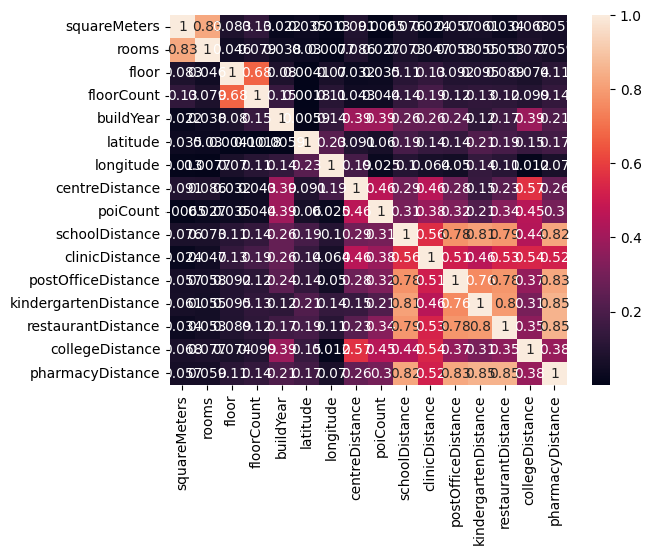

In [35]:
sns.heatmap(correlations_num, xticklabels=num_columns, yticklabels=num_columns, annot=True)

We can tell that 'squareMeters' and 'floor' are strongly correlated, but decided to keep squareMeters as more preceise measure. However, we decied to keep both 'floor' and 'floorCount' because they have different meaning despite being correlated.

In [36]:
X_train_full = X_train_full.drop("rooms", axis=1)
X_test_full = X_test_full.drop("rooms", axis=1)

All transformations on apartments dataframe are finished now and we know that we can drop 'rooms' column from the clean dataset:

In [37]:
df_apartments_1 = df_apartments_1.drop("rooms", axis=1).drop_duplicates()
df_apartments_1.to_csv("processed/apartments.csv", index=False)

## PCA

Similary we notice that all *Distance columns are more or less correlated and convienently are measured in the same unit, so we can replace them with surrogate features

In [38]:
cols_pca = [
    "schoolDistance",
    "clinicDistance",
    "postOfficeDistance",
    "kindergartenDistance",
    "restaurantDistance",
    "collegeDistance",
    "pharmacyDistance",
]
X_train_correlated = X_train_full[cols_pca]
X_test_correlated = X_test_full[cols_pca]

We expect new PCA components to provide 90% of variance explainability:

In [39]:
pca = PCA(n_components=0.9)
pc_X_train = pca.fit_transform(X_train_correlated)
pc_X_test = pca.transform(X_test_correlated)

We can see that number of features has been reduced from 7 to 4

In [40]:
pca.explained_variance_ratio_

array([0.68857084, 0.14116718, 0.06318774, 0.0357231 ])

And those features provide 92% vairance explainability

In [41]:
pca.explained_variance_ratio_.cumsum()  # indeed >0.9

array([0.68857084, 0.82973802, 0.89292576, 0.92864886])

After adding new columns to the original dataset:

In [42]:
X_train_pca = pd.concat(
    [
        X_train_full.drop(cols_pca, axis=1),
        pd.DataFrame(data=pc_X_train, columns=[f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))]),
    ],
    axis=1,
)
X_test_pca = pd.concat(
    [
        X_test_full.drop(cols_pca, axis=1),
        pd.DataFrame(data=pc_X_test, columns=[f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))]),
    ],
    axis=1,
)

we see there are no specific correlations between numeric features:

<Axes: >

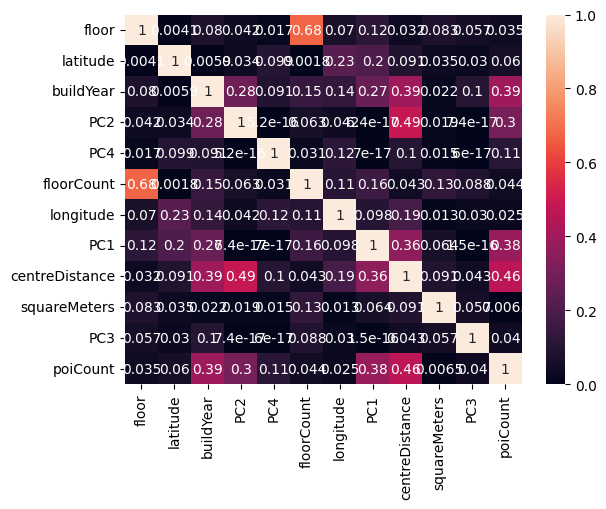

In [43]:
num_columns = list(
    set(num_columns)
    .difference(set(cols_pca))
    .union(set([f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))])),
)
num_columns.remove("rooms")
correlations_num = X_train_pca[num_columns].corr().abs()
sns.heatmap(correlations_num, xticklabels=num_columns, yticklabels=num_columns, annot=True)

Variance

We can also confirm none of features is low in variance:

In [44]:
mask = X_train_pca.var() < 0.1
print(any(mask))

False


Let's try to use this dataset to build ML model - it's mock run, to see if we get more or less sensible results

In [45]:
model1 = fit_transform_display(ens.RandomForestRegressor, X_train_pca, y_train, X_test_pca, y_test)

Model train score: 0.9835786635171891
Model test score: 0.8810708666424246
RMSE: 120017.92810044654
MAPE: 0.11389012185487062


/home/piotr/projects/ml-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In the first attempt we received 11% percentage error with Random Forrest but model is overfitted (test score is lower than train score). Let's try with another set of parameters:

In [47]:
model2 = fit_transform_display(
    ens.RandomForestRegressor,
    X_train_pca,
    y_train,
    X_test_pca,
    y_test,
    {"max_depth": 5, "n_estimators": 200, "n_jobs": -1},
)

Model train score: 0.7633448515334522
Model test score: 0.7425967743985995
RMSE: 176566.77737363646
MAPE: 0.20308558088293996


/home/piotr/projects/ml-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Now model is (almost) not overfitted but it has much worse results. Let's try to find best model systematically. For further analysis we'll use the processed file we saved earlier in 'processed' directory and apply following operations after each train/test split:
* OHE
* Scaling
* Imputing missing values
* Creating PCA features for each case independently. For this purpose I created custom PCA Transformer that executes required transformations.
* Applying the chosen algoritm against given set of parameters

We are going to use the original dataset that we saved before One Hot Encoding and PCA

In [48]:
df = pd.read_csv("processed/apartments.csv")
target = config["sources"]["apartments"]["target"]
X = df.drop(target, axis=1)
y = df[target]
X_perm = X.sample(frac=1)
y_perm = df.loc[X_perm.index, target]
X_perm[X_perm.select_dtypes("object").columns.to_list()] = X_perm[
    X_perm.select_dtypes("object").columns.to_list()
].astype("category")
cat_cols = list(X_perm.select_dtypes("category").columns.values)
num_cols = list(X_perm.select_dtypes("number").columns.values)

In [49]:
from sklearn.compose import ColumnTransformer

preprocess_get_columns = ColumnTransformer(
    [
        ("cat_cols", OneHotEncoder(sparse_output=False, dtype=np.uint8), cat_cols),
        ("num_cols", StandardScaler(), num_cols),
    ],
)
preprocess_get_columns.fit(X_perm)
columns_after_preprocess = preprocess_get_columns.get_feature_names_out(X_perm.columns)
preprocess = ColumnTransformer(
    [
        ("cat_cols", OneHotEncoder(sparse_output=False, dtype=np.uint8), cat_cols),
        ("num_cols", StandardScaler(), num_cols),
    ],
)
pipeline = Pipeline(
    steps=[
        ("preproces", preprocess),
        ("missing", KNNImputer(n_neighbors=5)),
        ("pca", PCA_Transform(columns_after_preprocess)),
        ("rf", ens.RandomForestRegressor()),
    ],
)
grid = {
    "rf__n_estimators": [500, 600, 700],
    "rf__max_depth": [5, 10, 15],
    "rf__random_state": [18],
}

In [50]:
random_grid = GridSearchCV(
    pipeline,
    param_grid=grid,
    cv=3,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=-1,
    return_train_score=True,
    verbose=True,
)
random_grid.fit(X_perm, y_perm)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproces',
                                        ColumnTransformer(transformers=[('cat_cols',
                                                                         OneHotEncoder(dtype=<class 'numpy.uint8'>,
                                                                                       sparse_output=False),
                                                                         ['city',
                                                                          'type',
                                                                          'ownership',
                                                                          'hasParkingSpace',
                                                                          'hasBalcony',
                                                                          'hasElevator',
                                                                          'hasSecurity',
                                                                          'hasStorageRoom']),
                                                                        ('num_cols',
                                                                         StandardScaler(),
                                                                         ['squareMeters',
                                                                          'floor',
                                                                          'floorCount',
                                                                          'buildYear',
                                                                          'lat...
       'num_cols__postOfficeDistance', 'num_cols__kindergartenDistance',
       'num_cols__restaurantDistance', 'num_cols__collegeDistance',
       'num_cols__pharmacyDistance'], dtype=object))),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, 15],
                         'rf__n_estimators': [500, 600, 700],
                         'rf__random_state': [18]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error', verbose=True)

In [51]:
best_run(random_grid.cv_results_)

Number of not overfitted results 6
Best result:
Train: -0.09584373947783557
Test:-0.12280155079569866
Best params: {'rf__max_depth': 10, 'rf__n_estimators': 600, 'rf__random_state': 18}


{'rf__max_depth': 10, 'rf__n_estimators': 600, 'rf__random_state': 18}

## Feature selection with PCA

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_perm, y_perm, test_size=0.2, random_state=12)

In [53]:
X_train_pca = pd.concat(
    [
        X_train.drop(cols_pca, axis=1),
        pd.DataFrame(data=X_train, columns=[f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))]),
    ],
    axis=1,
)
X_test_pca = pd.concat(
    [
        X_test.drop(cols_pca, axis=1),
        pd.DataFrame(data=X_test, columns=[f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))]),
    ],
    axis=1,
)

In [54]:
preprocess = ColumnTransformer(
    [
        ("cat_cols", OneHotEncoder(sparse_output=False, dtype=np.uint8), cat_cols),
        ("num_cols", StandardScaler(), list(set(num_cols).difference(set(cols_pca)))),
    ],
)

Let's define all transformations, but this time without PCA:

In [55]:
pipeline = Pipeline(
    steps=[
        ("preproces", preprocess),
        ("missing", KNNImputer(n_neighbors=5)),
        ("rf", ens.RandomForestRegressor(n_estimators=500, max_depth=10, random_state=18)),
    ],
)

In [56]:
best_model = pipeline.fit(X_train_pca, y_train)

In [58]:
r = permutation_importance(best_model, X_test_pca, y_test, n_repeats=10, random_state=17, n_jobs=-1)

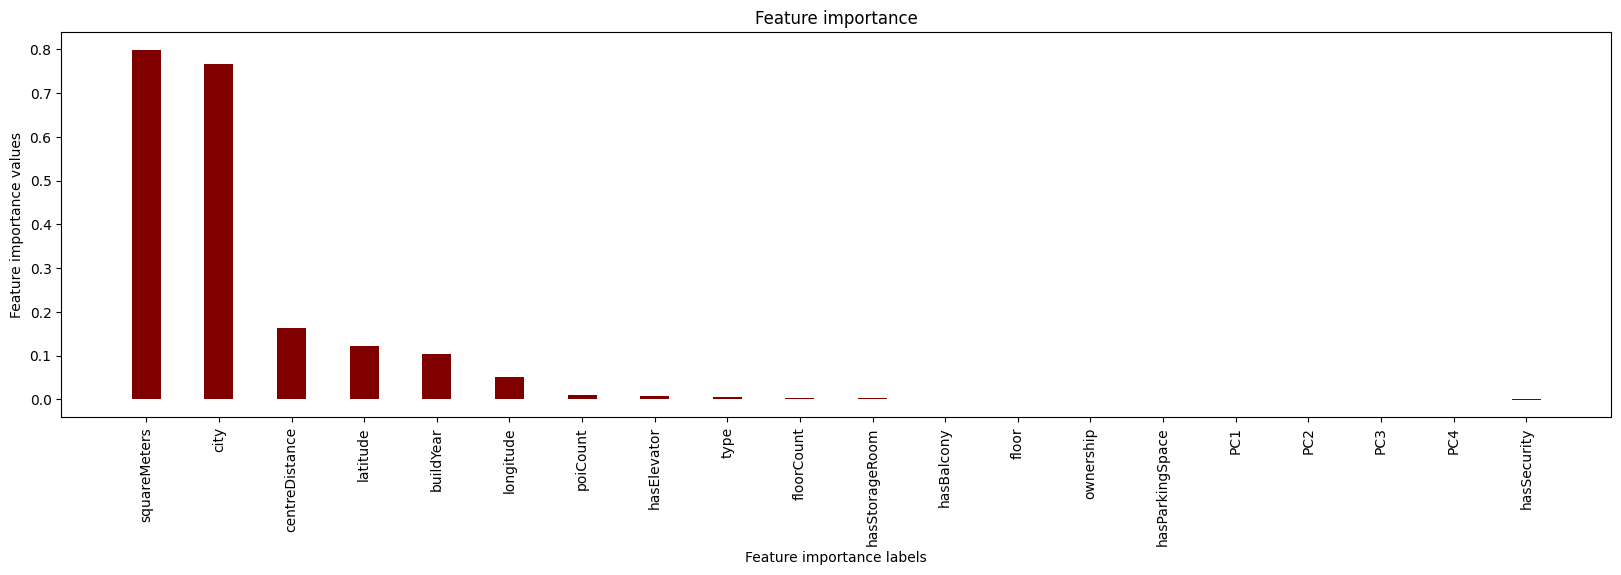

In [59]:
values = list(r["importances_mean"])
mapping = list(zip(X_test_pca.columns, values))
mapping.sort(key=lambda x: x[1], reverse=True)
mapping = dict(mapping)
fig = plt.figure(figsize=(20, 5))
plt.bar(mapping.keys(), mapping.values(), color="maroon", width=0.4)
plt.xlabel("Feature importance labels")
plt.xticks(rotation="vertical")
plt.ylabel("Feature importance values")
plt.title("Feature importance")
plt.show()

Let's check performance of model with reduced number of features

In [60]:
selected_columns = ["city", "squareMeters", "centreDistance", "buildYear", "latitude", "longitude"]
X_sel = X_perm[selected_columns]
y_sel = y_perm

In [61]:
cat_cols = list(X_sel.select_dtypes("category").columns.values)
num_cols = list(X_sel.select_dtypes("number").columns.values)

In [62]:
from sklearn.compose import ColumnTransformer

preprocess = ColumnTransformer(
    [
        ("cat_cols", OneHotEncoder(sparse_output=False, dtype=np.uint8), cat_cols),
        ("num_cols", StandardScaler(), num_cols),
    ],
)

In [63]:
pipeline = Pipeline(
    steps=[("preproces", preprocess), ("missing", KNNImputer(n_neighbors=5)), ("rf", ens.RandomForestRegressor())],
)
grid = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [5, 10, 15, 20],
    "rf__random_state": [18],
}

In [64]:
random_grid = GridSearchCV(
    pipeline,
    param_grid=grid,
    cv=3,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=-1,
    return_train_score=True,
    verbose=True,
)
random_grid.fit(X_sel, y_sel)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproces',
                                        ColumnTransformer(transformers=[('cat_cols',
                                                                         OneHotEncoder(dtype=<class 'numpy.uint8'>,
                                                                                       sparse_output=False),
                                                                         ['city']),
                                                                        ('num_cols',
                                                                         StandardScaler(),
                                                                         ['squareMeters',
                                                                          'centreDistance',
                                                                          'buildYear',
                                                                          'latitude',
                                                                          'longitude'])])),
                                       ('missing', KNNImputer()),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, 15, 20],
                         'rf__n_estimators': [200, 400, 600],
                         'rf__random_state': [18]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error', verbose=True)

In [65]:
best_run(random_grid.cv_results_)

Number of not overfitted results 6
Best result:
Train: -0.09973159982066114
Test:-0.12474690687231997
Best params: {'rf__max_depth': 10, 'rf__n_estimators': 600, 'rf__random_state': 18}


{'rf__max_depth': 10, 'rf__n_estimators': 600, 'rf__random_state': 18}

As we can see our final model MAPE is 12.5% which is almost as good as best result achieved previously but with tolerable test-train score difference.

## All columns

Let's see what would be resulf if we tried to select most influential columns without PCA reduction:

In [66]:
df = pd.read_csv("processed/apartments.csv")
target = config["sources"]["apartments"]["target"]
X = df.drop(target, axis=1)
y = df[target]
X_perm = X.sample(frac=1)
y_perm = df.loc[X_perm.index, target]
X_perm[X_perm.select_dtypes("object").columns.to_list()] = X_perm[
    X_perm.select_dtypes("object").columns.to_list()
].astype("category")
cat_cols = list(X_perm.select_dtypes("category").columns.values)
num_cols = list(X_perm.select_dtypes("number").columns.values)

In [67]:
from sklearn.compose import ColumnTransformer

preprocess = ColumnTransformer(
    [
        ("cat_cols", OneHotEncoder(sparse_output=False, dtype=np.uint8), cat_cols),
        ("num_cols", StandardScaler(), num_cols),
    ],
)
pipeline = Pipeline(
    steps=[("preproces", preprocess), ("missing", KNNImputer(n_neighbors=5)), ("rf", ens.RandomForestRegressor())],
)
grid = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [5, 10, 15, 20],
    "rf__random_state": [18],
}

In [68]:
random_grid = GridSearchCV(
    pipeline,
    param_grid=grid,
    cv=3,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=-1,
    return_train_score=True,
    verbose=True,
)
random_grid.fit(X_perm, y_perm)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproces',
                                        ColumnTransformer(transformers=[('cat_cols',
                                                                         OneHotEncoder(dtype=<class 'numpy.uint8'>,
                                                                                       sparse_output=False),
                                                                         ['city',
                                                                          'type',
                                                                          'ownership',
                                                                          'hasParkingSpace',
                                                                          'hasBalcony',
                                                                          'hasElevator',
                                                                          'hasSecurity',
                                                                          'hasStorageRoom']),
                                                                        ('num_cols',
                                                                         StandardScaler(),
                                                                         ['squareMeters',
                                                                          'floor',
                                                                          'floorCount',
                                                                          'buildYear',
                                                                          'lat...
                                                                          'postOfficeDistance',
                                                                          'kindergartenDistance',
                                                                          'restaurantDistance',
                                                                          'collegeDistance',
                                                                          'pharmacyDistance'])])),
                                       ('missing', KNNImputer()),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, 15, 20],
                         'rf__n_estimators': [200, 400, 600],
                         'rf__random_state': [18]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error', verbose=True)

In [69]:
best_run(random_grid.cv_results_)

Number of not overfitted results 6
Best result:
Train: -0.09485877329425892
Test:-0.12442064158418908
Best params: {'rf__max_depth': 10, 'rf__n_estimators': 600, 'rf__random_state': 18}


{'rf__max_depth': 10, 'rf__n_estimators': 600, 'rf__random_state': 18}

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_perm, y_perm, test_size=0.2, random_state=12)

In [71]:
pipeline = Pipeline(
    steps=[
        ("preproces", preprocess),
        ("missing", KNNImputer(n_neighbors=5)),
        ("rf", ens.RandomForestRegressor(n_estimators=600, max_depth=10, random_state=18)),
    ],
)

In [72]:
best_model = pipeline.fit(X_train, y_train)

In [73]:
r = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=13, n_jobs=-1)

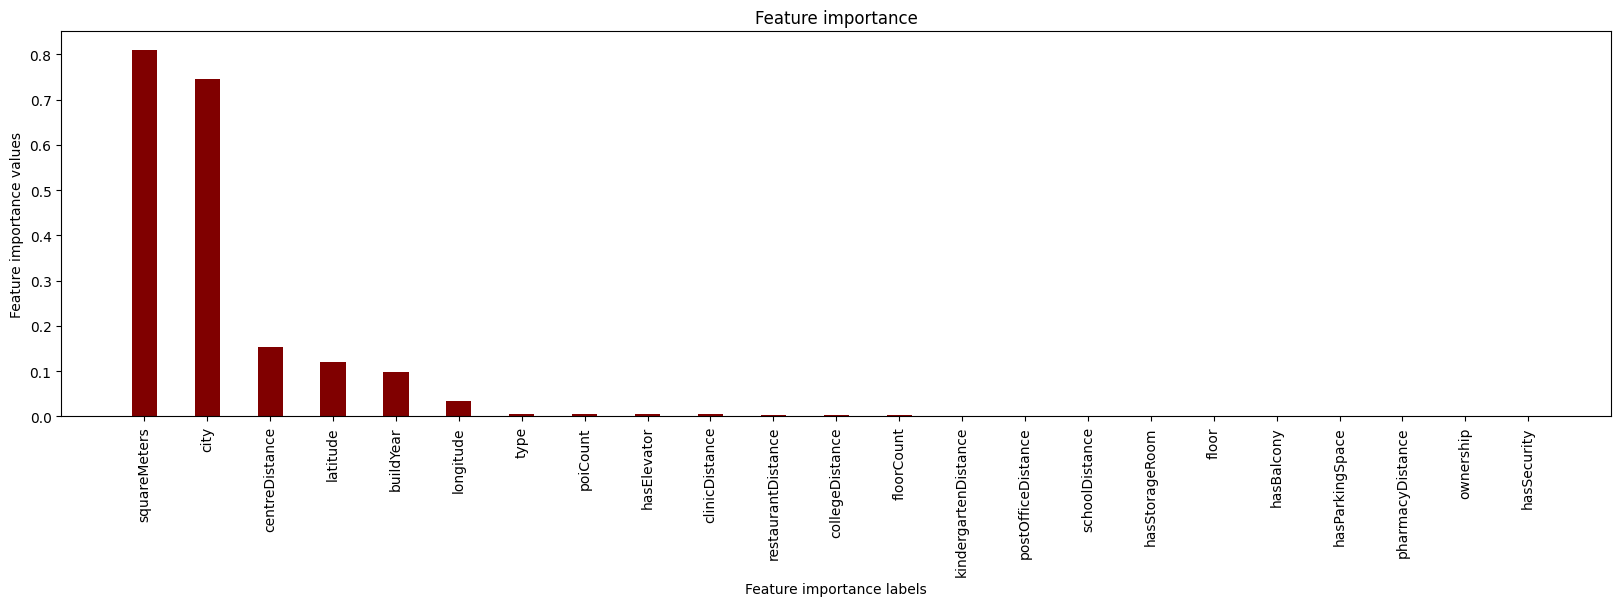

In [74]:
values = list(r["importances_mean"])
mapping = list(zip(X_test.columns, values))
mapping.sort(key=lambda x: x[1], reverse=True)
mapping = dict(mapping)
fig = plt.figure(figsize=(20, 5))
plt.bar(mapping.keys(), mapping.values(), color="maroon", width=0.4)
plt.xlabel("Feature importance labels")
plt.xticks(rotation="vertical")
plt.ylabel("Feature importance values")
plt.title("Feature importance")
plt.show()

We can see that now we've received the same set of columns o highest impact:

In [75]:
selected_columns = ["city", "squareMeters", "centreDistance", "buildYear", "latitude", "longitude"]

In [76]:
X_perm[X_perm.select_dtypes("object").columns.to_list()] = X_perm[
    X_perm.select_dtypes("object").columns.to_list()
].astype("category")
X_sel = X_perm[selected_columns]
y_sel = y_perm

cat_cols = list(X_sel.select_dtypes("category").columns.values)
num_cols = list(X_sel.select_dtypes("number").columns.values)

In [77]:
preprocess = ColumnTransformer(
    [
        ("cat_cols", OneHotEncoder(sparse_output=False, dtype=np.uint8), cat_cols),
        ("num_cols", StandardScaler(), num_cols),
    ],
)
pipeline = Pipeline(
    steps=[("preproces", preprocess), ("missing", KNNImputer(n_neighbors=5)), ("rf", ens.RandomForestRegressor())],
)
grid = {
    "rf__n_estimators": [200, 300, 400],
    "rf__max_depth": [5, 7, 9, 10, 12, 20],
    "rf__random_state": [18],
}

In [78]:
random_grid = GridSearchCV(
    pipeline,
    param_grid=grid,
    cv=3,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=-1,
    return_train_score=True,
    verbose=True,
)
random_grid.fit(X_sel, y_sel)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproces',
                                        ColumnTransformer(transformers=[('cat_cols',
                                                                         OneHotEncoder(dtype=<class 'numpy.uint8'>,
                                                                                       sparse_output=False),
                                                                         ['city']),
                                                                        ('num_cols',
                                                                         StandardScaler(),
                                                                         ['squareMeters',
                                                                          'centreDistance',
                                                                          'buildYear',
                                                                          'latitude',
                                                                          'longitude'])])),
                                       ('missing', KNNImputer()),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 7, 9, 10, 12, 20],
                         'rf__n_estimators': [200, 300, 400],
                         'rf__random_state': [18]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error', verbose=True)

In [79]:
best_run(random_grid.cv_results_)

Number of not overfitted results 15
Best result:
Train: -0.07940591296432103
Test:-0.12027443196463254
Best params: {'rf__max_depth': 12, 'rf__n_estimators': 400, 'rf__random_state': 18}


{'rf__max_depth': 12, 'rf__n_estimators': 400, 'rf__random_state': 18}

We can tell feature reduction without PCA give slightly better results due to lack of loosing information during execution of PCA reduction